In [ ]:
# We use monai dice loss
!pip install monai

In [ ]:
import cv2 as cv
import cv2
import numpy as np
import pandas as pd

import os
import sys

import nibabel as nib
import imageio
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from keras.utils import to_categorical

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from albumentations import Compose, Rotate, GaussNoise, RandomGamma, PadIfNeeded

from monai.losses.dice import *  # NOQA
from monai.losses.dice import DiceLoss

from unet import UNet

In [ ]:
# This block is to choose and download the train_validation data that was used in kaggle in ima205 challenge
! pip install -q kaggle

from google.colab import files

# Choose the kaggle.json file that you downloaded
files.upload()

# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json


# Download Data
!kaggle competitions download -c ima205-challenge-2023
! unzip -qq ima205-challenge-2023.zip

# Make results directory
! mkdir Results

In [ ]:
# Unzip the testing dataset, which is obtained from the ACDC dataset
!unzip testing.zip

In [2]:
# Load the training validation set from Train but load the test set from testing
def prepare_data(train_dir, test_gt_dir):
    train_ids = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    test_ids = sorted([d for d in os.listdir(test_gt_dir) if os.path.isdir(os.path.join(test_gt_dir, d))])

    # Prepare training data and masks
    train_images = []
    train_masks = []
    for train_id in train_ids:
        for phase in ['_ED', '_ES']:
            image_path = os.path.join(train_dir, train_id, train_id + phase + '.nii')
            mask_path = os.path.join(train_dir, train_id, train_id + phase + '_seg.nii')

            image = nib.load(image_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()

            train_images.append(image)
            train_masks.append(mask)

    # Prepare test data and ground truth masks
    test_images = []
    test_gt_masks = []
    slice_counts = {}
    for test_id in test_ids:
        patient_id = 'patient' + test_id[7:]  # remove 'patient' from test_id
        for phase in ['_ED', '_ES']:
            if phase == '_ED':
                image_path = os.path.join(test_gt_dir, patient_id, patient_id + '_frame01.nii.gz')
                mask_path = os.path.join(test_gt_dir, patient_id, patient_id + '_frame01_gt.nii.gz')
            else:  # For '_ES' phase, we need to find the correct frame
                patient_dir = os.path.join(test_gt_dir, patient_id)
                for file in os.listdir(patient_dir):
                    if 'frame' in file and 'gt' not in file and '01' not in file:  # Find the correct image file
                        image_path = os.path.join(patient_dir, file)
                    elif 'frame' in file and 'gt' in file and '01' not in file:  # Find the correct mask file
                        mask_path = os.path.join(patient_dir, file)

            image = nib.load(image_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()

            test_images.append(image)
            test_gt_masks.append(mask)

            # Check if the number of slices for the image and its ground truth are the same
            if image.shape[2] != mask.shape[2]:
                slice_counts[test_id+phase] = (image.shape[2], mask.shape[2])
    
    return train_images, train_masks, test_images, test_gt_masks, train_ids, test_ids


In [3]:
train_images, train_masks, test_image, test_gt_mask, train_ids, test_ids = prepare_data('Train', 'testing')

In [7]:
# Pre-process data. targe_shape is the processed slice size, it can used 256*256 or 128*128
def preprocess_data(train_images, train_masks, test_images, test_masks, train_ids, test_ids, target_shape=(128,128), save_cropped_path='./', save_resized_path='./', save_padded_path='./'):
    # Create lists to store processed slices
    proc_train_images = []
    proc_train_masks = []
    proc_test_images = []
    proc_test_masks = []

    new_train_ids = []  # Create a list to store new ids for train data
    new_test_ids = []  # Create a list to store new ids for test data

    for ids, images, masks, proc_images, proc_masks, new_ids in [(train_ids, train_images, train_masks, proc_train_images, proc_train_masks, new_train_ids),
                                                        (test_ids, test_images, test_masks, proc_test_images, proc_test_masks, new_test_ids)]:
        for idx, (image_id, image, mask) in enumerate(zip(ids, images, masks)):
            min_x, min_y, max_x, max_y = find_bounding_box(mask)  # Function to find the bounding box
            #print(min_x,min_y,max_x,max_y)
            for i in range(image.shape[2]):
                # Convert 3D images to 2D slices
                img_slice = image[..., i]
                mask_slice = mask[..., i]

                size = np.maximum((max_y-min_y),(max_x-min_x))

                # Crop images based on the bounding box
                img_slice = img_slice[min_x:min_x+size, min_y:min_y+size]
                mask_slice = mask_slice[min_x:min_x+size, min_y:min_y+size]

                # # Crop images based on the bounding box
                # img_slice = img_slice[min_x:max_x, min_y:max_y]
                # mask_slice = mask_slice[min_x:max_x, min_y:max_y]

                # Save cropped images and masks in folder "cropped_slices"
                if save_cropped_path is not None:
                    file_path = os.path.join(save_cropped_path, image_id)
                    os.makedirs(file_path, exist_ok=True)
                    plt.imsave(os.path.join(file_path, f'cropped_image_slice_{i}.png'), img_slice, cmap='gray')
                    plt.imsave(os.path.join(file_path, f'cropped_mask_slice_{i}.png'), mask_slice, cmap='gray')

                # # Pad images to have the same size
                # img_slice = pad_images([img_slice], *target_shape)[0]  # New function to add padding
                # mask_slice = pad_images([mask_slice], *target_shape)[0]  # New function to add padding

                # # Save padded images and masks
                # if save_padded_path is not None:
                #     file_path = os.path.join(save_padded_path, image_id)
                #     os.makedirs(file_path, exist_ok=True)
                #     plt.imsave(os.path.join(file_path, f'padded_image_slice_{i}.png'), img_slice, cmap='gray')
                #     plt.imsave(os.path.join(file_path, f'padded_mask_slice_{i}.png'), mask_slice, cmap='gray')

                # Resize images and masks before one-hot encoding and standardizing
                img_slice = cv2.resize(img_slice, target_shape, interpolation=cv2.INTER_LINEAR)  # For images
                mask_slice = cv2.resize(mask_slice, target_shape, interpolation=cv2.INTER_NEAREST)  # For masks

                # Save resized images and masks in folder "resized_slices"
                if save_resized_path is not None:
                    file_path = os.path.join(save_resized_path, image_id)
                    os.makedirs(file_path, exist_ok=True)
                    plt.imsave(os.path.join(file_path, f'resized_image_slice_{i}.png'), img_slice, cmap='gray')
                    plt.imsave(os.path.join(file_path, f'resized_mask_slice_{i}.png'), mask_slice, cmap='gray')

                proc_images.append(img_slice)
                # Data Stardarlization
                img_slice = (img_slice - img_slice.mean()) / img_slice.std() #######minmax //gamma augmentation// add gaussian noise

                # Append to the list
                
                proc_masks.append(to_categorical(mask_slice, num_classes=4))  # one-hot encoding
                # proc_masks.append(mask_slice)

                # Create a unique id for each slice
                new_ids.append(image_id + f"_slice_{i}")

    # Divide the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(proc_train_images, proc_train_masks, test_size=0.3, random_state=42)

    # Convert data to numpy arrays
    X_train = np.array(X_train)[..., np.newaxis]  # Add an extra dimension for channels
    y_train = np.array(y_train)
    X_val = np.array(X_val)[..., np.newaxis]
    y_val = np.array(y_val)
    test_image = np.array(proc_test_images)[..., np.newaxis]  # Add an extra dimension for channels
    test_mask = np.array(proc_test_masks)

    return X_train, y_train, X_val, y_val, test_image, test_mask, new_train_ids, new_test_ids

def find_bounding_box(mask):
    x_dims = []
    y_dims = []

    for i in range(mask.shape[2]):
        mask_slice = mask[..., i]
        nonzero = np.nonzero(mask_slice)
        if nonzero[0].size != 0:
            x_dims.append(nonzero[0].min())
            x_dims.append(nonzero[0].max())
            y_dims.append(nonzero[1].min())
            y_dims.append(nonzero[1].max())

    min_x, max_x = min(x_dims), max(x_dims)
    min_y, max_y = min(y_dims), max(y_dims)

    # Calculate the extension we need to add to the boundaries to get an area that is about 30% larger
    x_extension = int((max_x - min_x) * 0.15)
    y_extension = int((max_y - min_y) * 0.15)

    # Apply the extension to the boundaries, but also make sure we don't go outside the image dimensions
    min_x = max(0, min_x - x_extension)
    max_x = min(mask.shape[0], max_x + x_extension)
    min_y = max(0, min_y - y_extension)
    max_y = min(mask.shape[1], max_y + y_extension)

    return min_x, min_y, max_x, max_y

def pad_images(images, target_x, target_y):
    padded_images = []
    for img in images:
        pad_dims = [((target_x - s) // 2, (target_x - s + 1) // 2) if i == 1 else ((target_y - s) // 2, (target_y - s + 1) // 2) if i == 0 else (0, 0) for i, s in enumerate(img.shape)]
        padded_img = np.pad(img, pad_dims)
        padded_images.append(padded_img)
    return padded_images

In [8]:
X_train, y_train, X_val, y_val, test_images, test_masks, new_train_ids, new_test_ids = preprocess_data(train_images, train_masks, test_image, test_gt_mask, train_ids, test_ids, save_cropped_path='./cropped_slices', save_resized_path='./resized_slices', save_padded_path='./padded_slices')

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of test images: ", test_images.shape)
print("Shape of test masks: ", test_masks.shape)


Shape of X_train:  (659, 128, 128, 1)
Shape of y_train:  (659, 128, 128, 4)
Shape of X_val:  (283, 128, 128, 1)
Shape of y_val:  (283, 128, 128, 4)
Shape of test images:  (512, 128, 128, 1)
Shape of test masks:  (512, 128, 128, 4)


In [9]:
def get_training_augmentation():
    train_transform = [
        Rotate(limit=20, p=0.5),  # Image rotation
        RandomGamma(gamma_limit=(80, 120), p=0.5),  # Gamma enhancement
    ]
    return Compose(train_transform, is_check_shapes=False)


augmentation = get_training_augmentation()

class AugmentedDataset(Dataset):
    def __init__(self, data, targets, ids, augmentation):
        print("Before conversion, image shape: ", data.shape)
        self.data = torch.from_numpy(data).permute(0, 3, 1, 2).float()  # Change the dimension from (N, W, H, C) to (N, C, W, H) and convert to torch.Tensor
        print("After conversion, image shape: ", self.data.shape)
        print("Before conversion, target shape: ", targets.shape)
        self.targets = torch.from_numpy(targets).permute(0, 3, 1, 2).float()
        print("After conversion, target shape: ", self.targets.shape)
        self.ids = ids 
        self.augmentation = augmentation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        id = self.ids[index]  # Get id

        if self.augmentation:
            # convert tensor to numpy array for augmentation
            x_numpy = x.permute(1, 2, 0).numpy()  
            y_numpy = y.permute(1, 2, 0).numpy()  
            augmented = self.augmentation(image=x_numpy, mask=y_numpy)
            # convert back to tensor and rearrange dimensions
            x = torch.from_numpy(augmented['image']).permute(2, 0, 1).float()  
            y = torch.from_numpy(augmented['mask']).permute(2, 0, 1).float()



        return x, y, id

In [10]:
# Create instances of the dataset
train_dataset = AugmentedDataset(X_train, y_train, new_train_ids, augmentation)
val_dataset = AugmentedDataset(X_val, y_val, new_train_ids, None)


# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)



image shape before:  (659, 128, 128, 1)
image shape after:  torch.Size([659, 1, 128, 128])
Before conversion, target shape:  (659, 128, 128, 4)
After conversion, target shape:  torch.Size([659, 4, 128, 128])
image shape before:  (283, 128, 128, 1)
image shape after:  torch.Size([283, 1, 128, 128])
Before conversion, target shape:  (283, 128, 128, 4)
After conversion, target shape:  torch.Size([283, 4, 128, 128])


In [39]:
num_classes = 4
UseGpu = 1
if UseGpu == 1:
    if torch.cuda.is_available() == True:
        device = "cuda"
    else:
        device = 'mps'
else:
    device = "cpu"

# define model
model = UNet(in_channels=1, out_classes=num_classes, out_channels_first_layer=32, padding=1).to(device)  

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = DiceLoss(include_background=False, softmax=True, reduction='mean')  


Epoch [1/100], Train Loss: 0.8778, Validation Loss: 0.8761
Epoch [2/100], Train Loss: 0.8529, Validation Loss: 0.8249
Epoch [3/100], Train Loss: 0.7959, Validation Loss: 0.7979
Epoch [4/100], Train Loss: 0.7726, Validation Loss: 0.7523
Epoch [5/100], Train Loss: 0.7040, Validation Loss: 0.6601
Epoch [6/100], Train Loss: 0.6180, Validation Loss: 0.6405
Epoch [7/100], Train Loss: 0.5759, Validation Loss: 0.5703
Epoch [8/100], Train Loss: 0.5556, Validation Loss: 0.5415
Epoch [9/100], Train Loss: 0.5004, Validation Loss: 0.4958
Epoch [10/100], Train Loss: 0.4722, Validation Loss: 0.4750
Epoch [11/100], Train Loss: 0.4571, Validation Loss: 0.4657
Epoch [12/100], Train Loss: 0.4409, Validation Loss: 0.4467
Epoch [13/100], Train Loss: 0.4166, Validation Loss: 0.4388
Epoch [14/100], Train Loss: 0.4021, Validation Loss: 0.4242
Epoch [15/100], Train Loss: 0.3911, Validation Loss: 0.3995
Epoch [16/100], Train Loss: 0.3836, Validation Loss: 0.4044
Epoch [17/100], Train Loss: 0.3757, Validation Lo

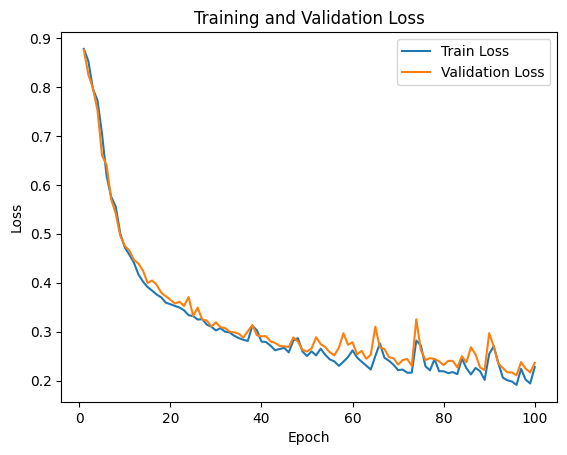

In [40]:
# train and save the best model
num_epochs = 100
train_losses = []
val_losses = []

best_model_path = 'best_model_resize.pth'
best_val_loss = np.inf

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for images, labels, _ in train_dataloader:
        # Load data to GPU
        images = images.to(device)
        labels = labels.to(device)
        # print("label shape: ", labels.shape)

        # Forward propagation
        outputs = model(images)
        # print("output shape: ", outputs.shape)

        # Compute loss
        loss = criterion(outputs, labels)

        # Back propagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)  # Get average loss
    train_losses.append(train_loss)

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Do not calculate gradients since we are not updating weights in validation phase
        for images, labels, _ in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        val_loss /= len(val_dataloader)  # Get average loss
        val_losses.append(val_loss)
        

    print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)


plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [41]:
# load the best model
best_model_path = 'best_model_resize.pth'
best_model = UNet()
best_model = UNet(in_channels=1, out_classes=4, out_channels_first_layer=32,padding=1).to(device) # Model instantiation
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation_layer): ReLU()
          (block): Sequential(
            (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
        )
        (conv2): ConvolutionalBlock(
          (conv_layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation_layer): ReLU()
          (block): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
          )
        )
        (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

In [42]:
# Create instances of the dataset
test_dataset = AugmentedDataset(test_images, test_masks, new_test_ids, None)

# Create data loaders
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

image shape before:  (512, 128, 128, 1)
image shape after:  torch.Size([512, 1, 128, 128])
Before conversion, target shape:  (512, 128, 128, 4)
After conversion, target shape:  torch.Size([512, 4, 128, 128])


In [43]:
# Predict on the test set and save the results in folder "predicted_masks" with .png format
def save_predicted_masks(dataloader, model, device, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    pred_masks = []
    # Iterate over all images in the dataloader
    for i, (inputs, _, ids) in enumerate(dataloader):  # Notice that we are ignoring labels here
        inputs = inputs.to(device)  # Move to device
        outputs = model(inputs)  # Get model output

        # Move outputs from GPU to CPU and convert to numpy array
        outputs_np = outputs.cpu().detach().numpy()

        # Get predicted class as the one with the highest probability
        pred_mask = np.argmax(outputs_np, axis=1)
        pred_masks.append(pred_mask)
        # Save each predicted mask as a PNG image
        for j, pred_mask in enumerate(pred_mask):
            # Get corresponding id
            id = ids[j]

            # Create a directory to save predicted masks for the subject with given id
            output_dir = os.path.join(output_folder, id.split("_slice_")[0])  # Use id before "_slice_" as directory name
            os.makedirs(output_dir, exist_ok=True)

            img = Image.fromarray((pred_mask * 255 / 3).astype(np.uint8))  # Convert to 8-bit unsigned integer to save as PNG
            img.save(os.path.join(output_dir, f"{id}.png"))  # Use full id as file name
    
    return pred_masks

pred_masks = save_predicted_masks(test_dataloader, best_model, device, 'predicted_masks')

In [44]:
def compute_average_dice_per_class(dataloader, model, device):
    # Create DiceLoss, set reduction='none'
    dice_loss = DiceLoss(include_background=False, softmax=False, reduction='none') 

    # Store Dice scores for all images
    all_dice_scores = []

    # Iterate over all images in the dataloader
    for inputs, targets, _ in dataloader:
        inputs = inputs.to(device)  # Move to device
        targets = targets.to(device)  # Also move targets to device

        with torch.no_grad():  
            outputs = model(inputs)  # Get model output

        # Use argmax to get the category prediction for each pixel
        outputs = torch.argmax(outputs, dim=1)

        # Converting single-channel category predictions to multi-channel one-hot codes
        outputs = F.one_hot(outputs, num_classes=4).permute(0, 3, 1, 2).float().to(device)

        # Calculating the Dice score
        dice_scores = 1 - dice_loss(outputs, targets)  # 1 - Dice Loss = Dice Score

        # Add the Dice score of this batch to the list
        all_dice_scores.append(dice_scores)

    # Concatenate all Dice scores into a tensor and calculate the average Dice score for each category
    all_dice_scores = torch.cat(all_dice_scores, dim=0)  # Shape: (num_images, num_classes)
    avg_dice_scores_per_class = all_dice_scores.mean(dim=0).cpu().numpy()

    return avg_dice_scores_per_class

In [45]:
# Use the best model to predict and output the dice loss for each category and the average dice loss for the entire validation set
avg_dice_val = compute_average_dice_per_class(val_dataloader, best_model, device)
print('Validation - Average Dice scores per class:', avg_dice_val)
print('Validation - Overall Average Dice score:', np.mean(avg_dice_val))


Validation - Average Dice scores per class: [[[0.66924435]]

 [[0.8236844 ]]

 [[0.87752205]]]
Validation - Overall Average Dice score: 0.7901502


In [46]:
# Use the best model to predict and output the dice loss for each category and the average dice loss for the entire test set (acdc test set)
avg_dice_test = compute_average_dice_per_class(test_dataloader, best_model, device)
print('Test - Average Dice scores per class:', avg_dice_test)
print('Test - Overall Average Dice score:', np.mean(avg_dice_test))


Test - Average Dice scores per class: [[[0.6701724]]

 [[0.7282115]]

 [[0.8313494]]]
Test - Overall Average Dice score: 0.7432444


In [47]:
pred_masks = np.array(pred_masks)
pred_mask = pred_masks.reshape((pred_masks.shape[0]*pred_masks.shape[1], pred_masks.shape[2], pred_masks.shape[3]))

true_labels = np.argmax(test_masks, axis=3)
predicted_labels = pred_mask
acc = []
f1 = []
pre = []
rc = []
for i in range(true_labels.shape[0]):
    # Flattening real and predicted labels into a one-dimensional array
    true_labels_flat = true_labels[i].flatten()
    predicted_labels_flat = predicted_labels[i].flatten()

    # Calculate the accuracy rate
    acc.append(accuracy_score(true_labels_flat, predicted_labels_flat))

    # Calculating the F1 score
    f1.append(f1_score(true_labels_flat, predicted_labels_flat, average='macro'))

    # Calculating the recall rate
    rc.append(recall_score(true_labels_flat, predicted_labels_flat, average='macro', zero_division=1))

    # Calculation accuracy
    pre.append(precision_score(true_labels_flat, predicted_labels_flat, average='macro', zero_division=1))

    
    
accuracy = np.mean(acc)
f1score = np.mean(f1)
recall = np.mean(rc)
precision = np.mean(pre)  
print("Accuracy:", accuracy)
print("F1 score:", f1score)
print("Recall:", recall)
print("Precision:", precision)


Accuracy: 0.9330567121505737
F1 score: 0.7951444142095287
Recall: 0.8925610154767653
Precision: 0.8008387460454293


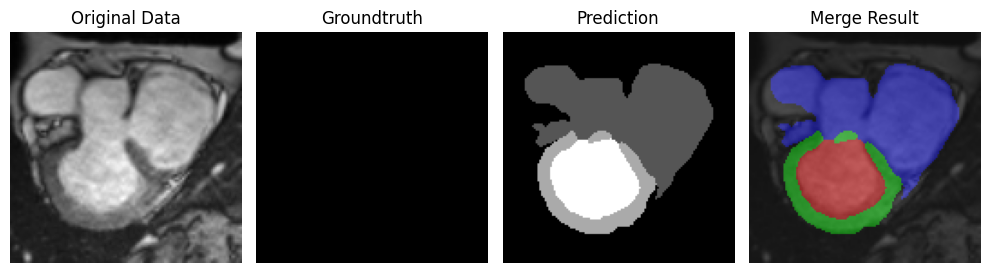

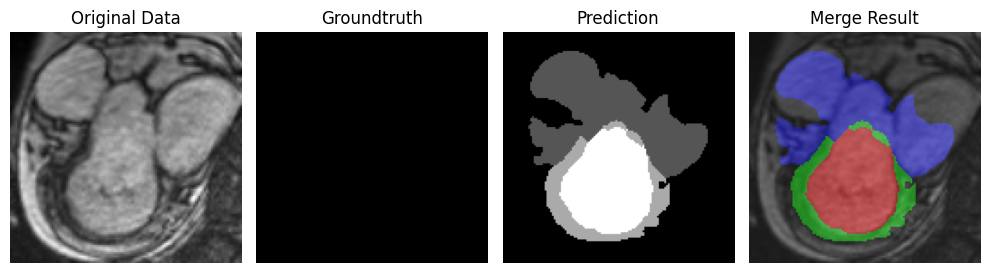

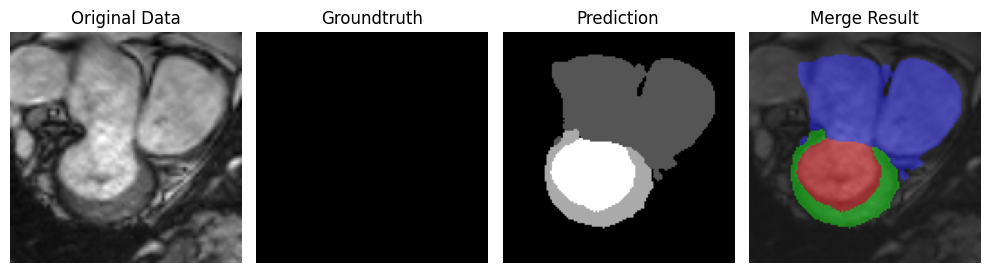

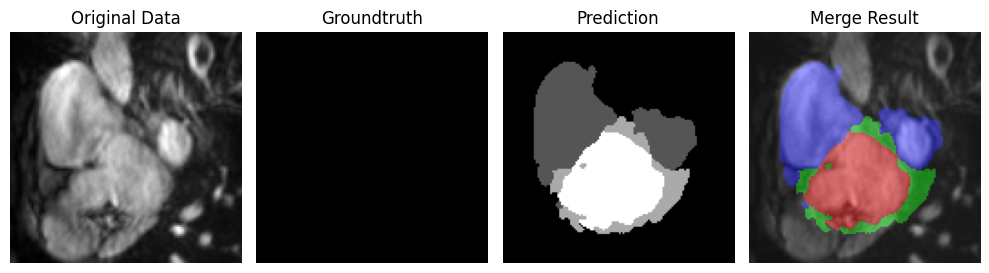

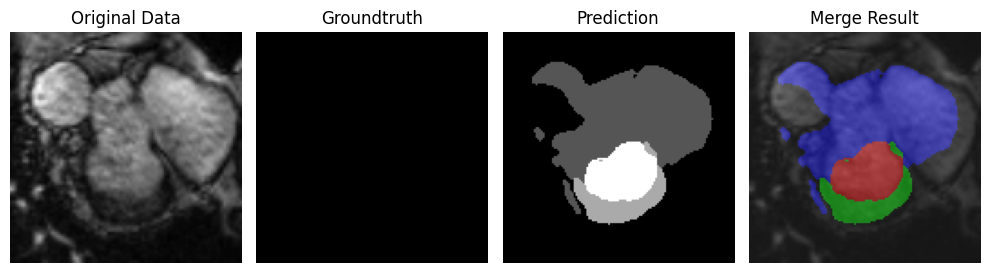

In [48]:
score = (np.array(acc)+np.array(f1)+np.array(rc)+np.array(pre))/4

# Find the 5 indexes with the highest F1 scores

best_indices = np.argsort(score)[:5]
# 5 images showing predicted results
for index in best_indices:
    # Get the corresponding image, true label and prediction results
    # Original uncropped image
    image = test_images[index]*255
    background= test_images[index]
    ground_truth = true_labels[index]*255/3
    prediction = pred_mask[index]*255/3

    # Adjust the aspect ratio of the image so that it fills the entire axis
    plt.figure(figsize=(10, 3))

    # Show original image
    plt.subplot(141)
    plt.imshow(image,cmap='gray')
    plt.title("Original Data")
    plt.axis('off')

    # Show real labels
    plt.subplot(142)
    plt.imshow(ground_truth,cmap='gray')
    plt.title("Groundtruth")
    plt.axis('off')

    # Show prediction results
    plt.subplot(143)
    plt.imshow(prediction,cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(144)
    color_image = np.zeros((background.shape[0], background.shape[1], 3), dtype=np.uint8)
    color_image[pred_mask[index] == 1] = (0, 0, 255)
    color_image[pred_mask[index] == 2] = (0, 255, 0)
    color_image[pred_mask[index] == 3] = (255, 0, 0)
    background = background.astype(np.uint8)
    result_image = cv2.addWeighted(cv2.cvtColor(background, cv2.COLOR_GRAY2BGR), 0.6, color_image, 0.4, 0)
    plt.imshow(result_image)
    plt.title("Merge Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    #print(score[index])